In [1]:
#import the maths/stats modules
import numpy as np
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import pandas,os

#import mcmc model
import pymc3 as pm
import arviz as az
# tell arviz to load all the data rather than do lazy loading
# I think this reduces file access issues later 
az.rcParams['data.load'] = 'eager'

#import plotting modules and do some settings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')
seaborn.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')   # There is a warning about a deprecated function. 
                                    # It's in theano so there is nothing we can do about it

# Simulated Data Generation

In [2]:
def calculate_directions(data):
    '''Calculate the scattering vector components for a simple transmission geometry, high E, setup.
    
    Parameters
    ----------
    gamma : array-like
        The angle around the detector.
    '''
    data = data.copy()
    data['h1'] = np.cos(data['gamma'])
    data['h2'] = np.sin(data['gamma'])
    data['h3'] = np.zeros(data.shape[0]) #nearly zero for high energy (low 2theta)
    return data

def calculate_stress_factors(data,E,v,components='11,22,12'):
    '''Calculate the stress factor for a measurement direction. 
    
    Parameters
    ----------
    data : pandas dataframe containing columns 'h1','h2','h3' 
        (3 x m) array of direction vector components for scattering vector  
    E: float
         Young's modulus of the material (isotropic)
    v: float
        Poisson's ratio for the material (isotropic)
    components: string
        Which tensor components do you want in 2 digit, comma-separated string
    '''        
    
    #this is a cheap copy, only creating new indices, etc - no bulk copying of the underlying data
    data = data.copy()
    
    comps = [[int(c) for c in comp] for comp in components.split(',')]
    
    for row,(i,j) in enumerate(comps):
        hi,hj = data['h{}'.format(i)],data['h{}'.format(j)]
        label = 'p{}{}'.format(i,j)
        data[label] = (1+v)*hi*hj 
        if i==j:
            data[label] -= v
        else:
            data[label] *= 2
        data[label]*=(1./E)
        
    return data

def generate_stress(data,groupby,label,function,**kwargs):
    data = data.copy()
    for name,group in data.groupby(groupby):
        data.loc[name,label] = function(**kwargs)
    return data

def generate_strain(data):
    data=data.copy()
    p = data.filter(regex='^p[1-3]{2,2}$')
    s = data.filter(regex='^s[1-3]{2,2}$')
    data['strain'] = np.einsum("ij,ij->i", p, s)
    return data

def create_true_dataset(number_of_locations,E,v,stress):
    number_of_angles = 360
    gamma = np.arange(number_of_angles)*2*np.pi/number_of_angles
    true = np.vstack([np.repeat(np.arange(1,number_of_locations+1),number_of_angles), #give each location an id number
                      np.tile(np.arange(number_of_angles),number_of_locations)])   #give each angle an id number
    true = pandas.DataFrame(true.T,columns=['location','measurement']) #create the dataframe

    true['gamma'] = np.tile(gamma,number_of_locations)
    true = true.set_index(['location','measurement'])

    true = calculate_directions(true)
    true = calculate_stress_factors(true,E,v,components=','.join(stress.keys()))
    
    for key,value in stress.items():
        true = generate_stress(true,'location','s{}'.format(key),np.random.normal,loc=value['mean'],scale=value['std']) #set scale to zero for no noise

    true = generate_strain(true)
    
    return true

def create_measurements(data,strain_err_range=(50e-6,150e-6),measurements_per_location=24):
    step = int(round(data.shape[0]/(len(data.groupby('location'))*measurements_per_location)))
    
    data = data.loc[::step,~data.columns.str.contains('^[h,s][0-3]{1,2}$')].copy()
    
    data['strain unc'] = np.random.uniform(low=strain_err_range[0],high=strain_err_range[1],size=data.shape[0])
    data['strain'] += np.random.normal(loc=0,scale=data['strain unc'])
    return data

# Create similated data

We make a dataframe of true stress and strain for reference later. Then make a set of measurments by extracting the data we would actually know (angles, stress factors, strain) then add noise to the strain and a measurement uncertainty

## Pooled

The strain in any given direction for any given location is assumed to result from a single overall stress tensor. All strains are fitted at the same time to give an overall estimate of the sample stress. No variation is allowed from location to location.

In [3]:

def run_lsq_pooled(data):
    #Make a copy of the data to save the fits in.
    lsq_fit = data.copy()
    
    #get stress factors from columns
    p = data.filter(regex='^[p][1-3]{2,2}$')
    #create a fitting model by supplying formula string
    # ~ means left side is linear function of right side
    # -1 removes the intercept that is otherwise added automatically (and wrongly in this case)
    # create a string of the form 'strain ~ p11 + p22 -1' to define the fitting process
    f = 'strain ~ {:} -1'.format(' + '.join(p.columns))

    # The weights correct for experimental precision - as far as I can tell it's meant to be reciprocal of uncertainty
    mod = smf.wls(formula='strain ~ p11 + p22 + p12 -1', data=lsq_fit, weights=1./lsq_fit['strain unc'])

    #this one is more powerful and generic but confusing if regular expressions are unknown
    # You don't need to know what stress components are present (p11, p12, etc) to make it work.
    #mod = sm.WLS(data['strain'],data.filter(regex='^p[0-3]{1,2}$'),weights=1./data['strain unc'])

    fit = mod.fit()

    #insert the fitted strains in a new column
    lsq_fit['fitted_strain'] = fit.predict() #predict gives the strain for the fitted parameters

    #now calculate the upper,lower confidence limits and add them in the same way
    prstd, iv_l, iv_u = wls_prediction_std(fit)
    lsq_fit['fitted_strain_cll'] = iv_l
    lsq_fit['fitted_strain_clu'] = iv_u

    #save the results in the dataframe. Every row has the same number but that's fine - pandas is very efficient with duplicates
    for i,column in enumerate(p.columns):
        label = 's{:}'.format(column.strip('p')) 
        lsq_fit[label] = fit.params[i] # add the refined stress
        lsq_fit[label+'_unc'] = fit.bse[i] # add the apparent uncertainty
    return lsq_fit


## Effect of prior accuracy and strength on pooled bayesian

In [4]:
def run_pymc_pooled(data,priors={},**kwargs):    
 
    data = data.copy()
    #extract the stress factors of the form pij for i,j = 1 to 3
    p = data.filter(regex='^[p][1-3]{2,2}$')

    with pm.Model(): #any distributions created below are automatically added to this model 

        #the stress is the sum of all the components so we create each distribution one at a time
        mu = []
        for column in p.columns: #create one at a time 
            label = 's{:}'.format(column.strip('p')) #i.e. factor p11 becomes stress s11
            stress = pm.Normal(label, 
                               mu= priors.get(label,{}).get('mu',0), #zero by default if not specified
                               sigma=priors.get(label,{}).get('sigma',1e5) #very weak prior if not specified
                               ) 
            mu.append(stress*p[column].values)
        mu = sum(mu) #we can just add distributions together like any number

        #sigma = pm.HalfNormal('sigma', sigma = 0.1)
        likelihood = pm.Normal('strain', mu=mu, sigma = data['strain unc'], observed=data['strain'].values)

        #do the inference 
        trace = pm.sample(draws=3000, tune=1000, cores=2,**kwargs)
        #sample data as though prior is correct
        prior = pm.sample_prior_predictive()
        #samples data with corrected prior distribution
        posterior_predictive = pm.sample_posterior_predictive(trace,**kwargs)

    #in order to save the traces and everything we create an inference object using arviz
    pm_data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)


    # save the predicted strain + credible interval to the frame
    data['fitted_strain'] = posterior_predictive['strain'].mean(axis=0)
    #add the 95% credible interval i.e. range that contains 95% of possible values for each location
    data['fitted_strain_cll'] = np.percentile(posterior_predictive['strain'],2.5,axis=0)
    data['fitted_strain_clu'] = np.percentile(posterior_predictive['strain'],97.5,axis=0)

    # save the stress outcome
    for name in trace.varnames:
        data[name] = trace[name].mean(axis=0)
        data['{:}_unc'.format(name)] = trace[name].std(axis=0)
        
    return data,pm_data

In [5]:
save_fname = 'effect_of_prior.h5'
 
with pandas.HDFStore(save_fname) as hdfstore:#by default opened in appendable mode

    keys = hdfstore.keys() #list of all saved datasets in the file

    # Create datasets using the same nominal underlying stress but different amounts of noise
    for strain_err in [250]: #microstrain error 

        #define a folder in the hdf file to save this set of experiments
        group = '/strainerr-{:}'.format(strain_err)

        if group not in keys: #then the data was never made - make the data
            #simple uniaxial stress state with some noise from location to location
            true = create_true_dataset(number_of_locations=5,E=210000,v=0.33,
                                       #for each stress component (keys of dictionary) we give a mean stress and standard dev
                                       stress={'11':{'mean':150,'std':20},'22':{'mean':50,'std':0},'12':{'mean':30,'std':0}})
            hdfstore.put('{:}/actual_strain'.format(group),true) #save the true signal for use later

            data = create_measurements(true,strain_err_range=(strain_err*1e-6,strain_err*1e-6),measurements_per_location=12)
            hdfstore.put('{:}/simulated_strain'.format(group),data) #save simulated experimental data

        else: #it's already there so lets load it
            data = hdfstore.get('{:}/simulated_strain'.format(group),data)


        #Run leastsquares fit on this data set
        if group+'/lsq' not in keys: #do the fit if no saved fit already
            lsqfit = run_lsq_pooled(data) #I've made a function for this but you could just put the code here
            lsqfit['strain_noise'] = strain_err #save the noise variable in the dataset for easy access later
            hdfstore.put(group+'/pooled/lsq',lsqfit) #save the dataset in the folder, call the node 'lsq'

        #Now run the bayesian for different priors
        for prior_mu in [0,150,500]: #different assumed mean stress

            for prior_sigma in [10,20,30,40,75,100,150]: #different prior strength

                #this is where we will store the result in a folder called 'baysian' under a folder called 'pooled'
                key = '{:}/pooled/bayesian/nu-{:}_sigma-{:}'.format(group,prior_mu,prior_sigma)

                if key not in keys: #then we need to run the fit

                    
                    #I made a function for this but we could just put explict code here
                    # Copy in whatever code you have and use the values created in the loops
                    bayfit,trace = run_pymc_pooled(data,priors={'s11':{'mu':prior_mu,'sigma':prior_sigma}},progressbar=False)
                    
                    
                    #record the variables for easy access later (saves us parsing the group name)
                    bayfit['strain_noise'] = strain_err
                    bayfit['prior_mu'] = prior_mu
                    bayfit['prior_sigma'] = prior_sigma

                    hdfstore.put(key,bayfit)
                    
                    # saving the traces is more of a pain since each fit needs a separate file.
                    # I'll nest folders instead of making long filenames
                    f = './{:}/pooled/'.format(group)
                    if not os.path.isdir(f):
                        os.makedirs(f)
                    trace.to_netcdf(f+'/nu-{:}_sigma-{:}.cdf'.format(prior_mu,prior_sigma))
                    
           

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '5252' (I am process '9372')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s12, s22, s11]
Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 108 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s12, s22, s11]
Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 79 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s12, s22, s11]
Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 72 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s12, s22, s11]
Sampling 2 chains f

Text(0, 0.5, 'Strain')

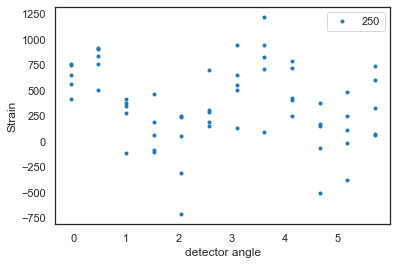

In [6]:
#check what the simulated strain data looks like

#open the file and run through all the keys, load the data we want
with pandas.HDFStore(save_fname) as hdfstore:
    data = []
    for key in hdfstore.keys():
        if ('/pooled/' in key and 'bayesian' in key):
            data.append(hdfstore.get(key))
#add them all together into one big dataframe, set exp parameters as the index  
data = pandas.concat(data).reset_index()#.set_index(['strain_noise','prior_mu','prior_sigma'])
# groupby the noise added to the strain data,location and the detector angle
# then get just the first line of each group since they just repeat for different mu and sigma 
data = data.groupby(['strain_noise','location','gamma']).first().reset_index()

#plot strains with groups of different noise slightly jittered in gamma to improve readability
jitter=-0.05
f,ax = plt.subplots()
for name,group in data.groupby('strain_noise'):
    #print(group)
    ax.plot(group['gamma']+jitter,group['strain']*1e6,'.',label=name)
    jitter+=0.05
ax.legend()
ax.set_xlabel('detector angle')
ax.set_ylabel('Strain')

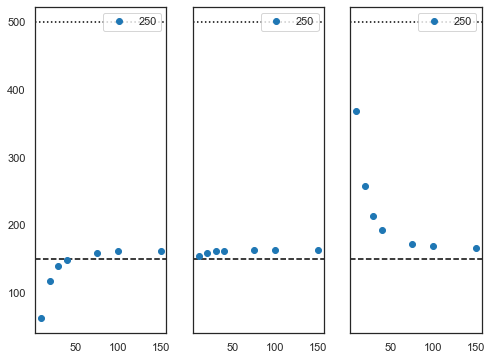

In [9]:
with pandas.HDFStore(save_fname) as hdfstore:
    data = []
    for key in hdfstore.keys():
        if ('/pooled/' in key and 'bayesian' in key):
            data.append(hdfstore.get(key))
            
data = pandas.concat(data).reset_index()
data = data[data['prior_sigma']<300]

data = data.groupby(['strain_noise','prior_mu','prior_sigma']).first().reset_index()

mu_groups = data.groupby('prior_mu')

f,axs = plt.subplots(1,len(mu_groups),sharex=True,sharey=True,figsize=(8,6))

for ax,(mu,group) in zip(axs,mu_groups):
    
    for noise,mgroup in group.groupby('strain_noise'):
        ax.plot(mgroup['prior_sigma'],mgroup['s11'],'o',label=noise)
    ax.legend()
    
    xlim=ax.get_xlim()
    ax.hlines(prior_mu,*xlim,linestyles=':')
    ax.hlines(150,*xlim,linestyles='--')
    ax.set_xlim(*xlim)